In [1]:
try:
    import torch._dynamo
    torch._dynamo.disable()
    print("⚙️ TorchDynamo 已禁用")
except Exception:
    pass

⚙️ TorchDynamo 已禁用


In [2]:
import random
import copy
import numpy as np
from itertools import combinations
from enum import Enum

###########################
# 枚举定义：动作与阶段
###########################
class Action(Enum):
    """
    定义可执行的动作：
    - FOLD: 弃牌
    - CALL: 跟注/看牌
    - RAISE: 加注
    """
    FOLD = 0
    CALL = 1
    RAISE = 2

class Stage(Enum):
    """
    - RIVER: 河牌
    - SHOWDOWN: 摊牌
    """
    PREFLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3
    SHOWDOWN = 4

###########################
# 扑克牌评估函数
###########################
class Card:
    """
    表示一张扑克牌，包括点数和花色。
    """
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
    def __repr__(self):
        return f"{self.rank}{self.suit}"


def create_deck():
    """
    生成并随机打乱一副标准 52 张扑克牌。
    返回列表形式的 Card 对象。
    """
    ranks = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    suits = ['H','D','C','S']
    deck = [Card(r,s) for r in ranks for s in suits]
    random.shuffle(deck)
    return deck


def card_value(c):
    """
    将 Card.rank 转换为对应的数值，A 为最大 (14)。
    用于比较牌型大小。
    """
    order = {'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'T':10,'J':11,'Q':12,'K':13,'A':14}
    return order[c.rank]


def check_straight(vals):
    """
    检查给定点数列表中是否存在顺子。
    返回 (是否顺子, 顺子最高点数)
    """
    vals = sorted(set(vals))
    if len(vals) < 5:
        return False, None
    for i in range(len(vals)-4):
        window = vals[i:i+5]
        if window[-1] - window[0] == 4:
            return True, window[-1]
    if {14,2,3,4,5}.issubset(vals):
        return True, 5
    return False, None


def evaluate_5card_hand(cards):
    """
    评估 5 张牌的手牌强度，返回元组。
    """
    vals = sorted([card_value(c) for c in cards], reverse=True)
    suits = [c.suit for c in cards]
    flush = len(set(suits)) == 1
    straight, high = check_straight(vals)
    freq = {v: vals.count(v) for v in vals}
    freq_sorted = sorted(freq.items(), key=lambda x:(x[1], x[0]), reverse=True)
    if flush and straight:
        return (8, high)
    if freq_sorted[0][1] == 4:
        four = freq_sorted[0][0]
        kick = max(v for v in vals if v != four)
        return (7, four, kick)
    if freq_sorted[0][1] == 3 and len(freq_sorted)>1 and freq_sorted[1][1]>=2:
        return (6, freq_sorted[0][0], freq_sorted[1][0])
    if flush:
        return (5, tuple(vals))
    if straight:
        return (4, high)
    if freq_sorted[0][1] == 3:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (3, freq_sorted[0][0], tuple(kickers))
    if len(freq_sorted)>=2 and freq_sorted[0][1]==2 and freq_sorted[1][1]==2:
        p1,p2 = freq_sorted[0][0], freq_sorted[1][0]
        kick = max(v for v in vals if v not in (p1,p2))
        return (2, max(p1,p2), min(p1,p2), kick)
    if freq_sorted[0][1] == 2:
        kickers = sorted([v for v in vals if v != freq_sorted[0][0]], reverse=True)
        return (1, freq_sorted[0][0], tuple(kickers))
    return (0, tuple(vals))


def evaluate_hand(hole, community):

    """
    从 7 张牌选最佳 5 张，返回评估结果。
    """

    best = (-1,)
    for combo in combinations(hole+community, 5):
        rank = evaluate_5card_hand(combo)
        if rank > best:
            best = rank
    return best

###########################
# 自定义环境：1v1 有限注 德州扑克（不依赖 gym）
###########################
class TexasHoldemEnv:
    """
    纯 Python 实现的 Heads-up Limit 德州扑克环境，
    不依赖任何外部框架，只用 reset/step 接口。
    """

    def __init__(self, starting_chips=100, small_blind=1, big_blind=2, max_raises=4):
        # 初始筹码与盲注设置
        self.starting_chips = starting_chips
        self.small_blind = small_blind
        self.big_blind = big_blind
        self.max_raises = max_raises
        # 内部状态
        self.reset()

    def reset(self):
        """
        重置环境状态：洗牌、发二人手牌、初始化彩池与阶段。
        返回初始观测向量。
        """
        self.deck = create_deck()
        self.community_cards = []
        self.pot = self.small_blind + self.big_blind
        self.stage = Stage.PREFLOP
        self.raises_this_round = 0
        self.round_actions = 0
        self.player_cards = [self.deck.pop(), self.deck.pop()]
        self.opponent_cards = [self.deck.pop(), self.deck.pop()]
        self.betting_sequence = []
        return self._get_observation()

    def _get_observation(self):
        """
        构建观测向量：
        [阶段 one-hot] + [彩池] + [玩家底牌点数] + [公共牌数]
        """
        stage_oh = [0]*len(Stage)
        stage_oh[self.stage.value] = 1
        hole_vals = [card_value(c) for c in self.player_cards]
        comm_len = len(self.community_cards)
        return stage_oh + [self.pot] + hole_vals + [comm_len]

    def _get_legal_moves(self):
        """
        计算合法动作：始终允许弃牌和跟注，未超加注上限可加注。
        """
        moves = [Action.FOLD.value, Action.CALL.value]
        if self.raises_this_round < self.max_raises:
            moves.append(Action.RAISE.value)
        return moves

    def step(self, action):
        """
        执行动作，推进环境。
        返回 (obs, reward, done, info)。
        info 包含 'result': 'win'/'lose'/'draw'/'fold'.
        """
        # 合法性检查
        if action not in self._get_legal_moves():
            return self._get_observation(), -1.0, False, {'result':'illegal'}
        act = Action(action)
        reward, done, info = 0, False, {}
        # 弃牌
        if act == Action.FOLD:
            reward, done, info['result'] = -self.big_blind, True, 'fold'
        else:
            # 跟注或加注
            bet = self.small_blind if act == Action.CALL else self.big_blind
            self.pot += bet
            if act == Action.RAISE:
                self.raises_this_round += 1
            self.round_actions += 1
            self.betting_sequence.append((self.stage.name, act.name))
            # 阶段推进
            if self.round_actions >= 2:
                self.round_actions = 0
                if self.stage == Stage.RIVER:
                    self.stage = Stage.SHOWDOWN
                else:
                    self.stage = Stage(self.stage.value + 1)
                self.raises_this_round = 0
            # 摊牌结算
            if self.stage == Stage.SHOWDOWN:
                pr = evaluate_hand(self.player_cards, self.community_cards)
                orank = evaluate_hand(self.opponent_cards, self.community_cards)
                if pr > orank:
                    reward, info['result'] = self.pot, 'win'
                elif pr < orank:
                    reward, info['result'] = -self.pot, 'lose'
                else:
                    info['result'] = 'draw'
                done = True
        # 发公共牌
        if not done and self.stage in (Stage.FLOP, Stage.TURN, Stage.RIVER) and self.round_actions == 0:
            if self.stage == Stage.FLOP:
                for _ in range(3): self.community_cards.append(self.deck.pop())
            else:
                self.community_cards.append(self.deck.pop())
        return self._get_observation(), reward, done, info

    def clone(self):
        """
        返回深拷贝，用于无副作用的模拟。
        """
        return copy.deepcopy(self)

if __name__ == '__main__':
    env = TexasHoldemEnv()
    obs = env.reset()
    print('Obs:', obs)
    obs, r, d, i = env.step(Action.CALL.value)

Obs: [1, 0, 0, 0, 0, 3, 10, 13, 0]


In [2]:
env = TexasHoldemEnv()
obs = env.reset()
print("玩家手牌：", env.player_cards)        # 比如 [Card('K','H'), Card('6','D')]
print("初始彩池：", env.pot)
print("---")
# 模拟两次“CALL”推动阶段到 FLOP
for i in range(2):
    obs, r, done, info = env.step(Action.CALL.value)
    print(f"Step {i+1} -> Stage: {env.stage.name}, 彩池={env.pot}, 公共牌={env.community_cards}")
# 接着再两次动作，推进到 TURN
for i in range(2):
    obs, r, done, info = env.step(Action.CALL.value)
print(f"转牌后公共牌（TURN）: {env.community_cards}")
# 再两次动作，推进到 RIVER
for i in range(2):
    obs, r, done, info = env.step(Action.CALL.value)
print(f"河牌后公共牌（RIVER）: {env.community_cards}")
# 最后一次动作进入 SHOWDOWN
obs, r, done, info = env.step(Action.CALL.value)
print(f"摊牌阶段(deal down)： 公共牌共 5 张 → {env.community_cards}")
print("结果 info：", info)

玩家手牌： [JC, TD]
初始彩池： 3
---
Step 1 -> Stage: PREFLOP, 彩池=4, 公共牌=[]
Step 2 -> Stage: FLOP, 彩池=5, 公共牌=[AS, TC, 5C]
转牌后公共牌（TURN）: [AS, TC, 5C, 5D]
河牌后公共牌（RIVER）: [AS, TC, 5C, 5D, 4S]
摊牌阶段(deal down)： 公共牌共 5 张 → [AS, TC, 5C, 5D, 4S]
结果 info： {}


In [27]:
import random
import copy
import numpy as np
from collections import deque, defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json


############################
# —— DQN & ReplayBuffer ——
############################
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=200_000):
        self.buf = deque(maxlen=capacity)
    def push(self, s, a, r, ns, done):
        self.buf.append((s, a, r, ns, done))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return s, a, r, ns, d
    def __len__(self):
        return len(self.buf)

def train_dqn(env,
              num_episodes=20_000,
              batch_size=64,
              gamma=0.99,
              lr=1e-3,
              epsilon_start=1.0,
              epsilon_end=0.1,
              epsilon_decay=10_000,
              target_update=1_000):
    obs_dim = len(env.reset())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    policy_net = DQN(obs_dim).to(device)
    target_net = DQN(obs_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer()

    epsilon = epsilon_start
    perf = []
    steps = 0

    for ep in range(1, num_episodes+1):
        state = np.array(env.reset(), dtype=np.float32)
        total_r = 0
        done = False

        while not done:
            # ε-贪心
            if random.random() < epsilon:
                action = random.choice(env._get_legal_moves())
            else:
                with torch.no_grad():
                    qvals = policy_net(torch.from_numpy(state).to(device))
                legal = env._get_legal_moves()
                mask = torch.full((len(Action),), -1e9, device=device)
                mask[legal] = 0
                action = int((qvals + mask).argmax().cpu().item())

            nxt_obs, r, done, _ = env.step(action)
            nxt_state = np.array(nxt_obs, dtype=np.float32)
            replay.push(state, action, r, nxt_state, done)

            state = nxt_state
            total_r += r
            steps += 1

            # 学习更新
            if len(replay) >= batch_size:
                s_b, a_b, r_b, ns_b, d_b = replay.sample(batch_size)
                s_b = torch.from_numpy(s_b).to(device)
                a_b = torch.from_numpy(a_b).long().to(device)
                r_b = torch.from_numpy(r_b).float().to(device)
                ns_b = torch.from_numpy(ns_b).to(device)
                d_b = torch.from_numpy(d_b).float().to(device)

                q_pred = policy_net(s_b).gather(1, a_b.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    q_next = target_net(ns_b).max(1)[0]
                q_target = r_b + gamma * q_next * (1 - d_b)
                loss = nn.functional.mse_loss(q_pred, q_target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 定期同步 target 网络
            if steps % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        # ε 衰减
        epsilon = max(epsilon_end,
                      epsilon_start - (epsilon_start - epsilon_end) * ep / epsilon_decay)
        perf.append(total_r)

        # 实时日志：每 2000 集打印最近平均回报
        if ep % 2000 == 0:
            avg_recent = np.mean(perf[-2000:])
            print(f"[DQN] Episode {ep}/{num_episodes}, AvgReward(last2000) = {avg_recent:.2f}")

    # 保存模型
    torch.save(policy_net.state_dict(), 'dqn_model.pt')
    return policy_net, perf

###########################
# —— Dueling Double DQN ——
###########################
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, hidden=256, output_dim=3):
        super().__init__()
        # 共享特征提取层
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
        # Value 流
        self.value_stream = nn.Sequential(
            nn.Linear(hidden, hidden//2), nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
        # Advantage 流
        self.adv_stream = nn.Sequential(
            nn.Linear(hidden, hidden//2), nn.ReLU(),
            nn.Linear(hidden//2, output_dim)
        )

    def forward(self, x):
        # 如果输入是一维向量，自动添加 batch 维度
        if x.dim() == 1:
            x = x.unsqueeze(0)
        f = self.feature(x)
        v = self.value_stream(f)           # [B, 1]
        a = self.adv_stream(f)             # [B, output_dim]
        # 合成 Q 值
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

class ReplayBuffer:
    def __init__(self, capacity=200_000):
        self.buf = deque(maxlen=capacity)
    def push(self, s,a,r,ns,d):
        self.buf.append((s,a,r,ns,d))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s,a,r,ns,d = map(np.array, zip(*batch))
        return s,a,r,ns,d
    def __len__(self):
        return len(self.buf)

def train_dueling_double_dqn(env,
                             num_episodes=100_000,
                             batch_size=128,
                             gamma=0.99,
                             lr=1e-4,
                             epsilon_start=1.0,
                             epsilon_end=0.05,
                             epsilon_decay=50_000,
                             target_update=2_000):
    """
    Dueling + Double DQN + Equity 特征
    """
    # 扩展输入：原 obs + 1 维 equity
    base_obs = env.reset()
    obs_dim  = len(base_obs) + 1
    device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    policy_net = DuelingDQN(obs_dim).to(device)
    target_net = DuelingDQN(obs_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer()

    epsilon = epsilon_start
    steps   = 0
    perf    = []

    for ep in range(1, num_episodes+1):
        raw_obs = env.reset()
        eq = estimate_equity(env, n_sim=20)  # 快速蒙特卡洛估率
        state = np.concatenate([raw_obs, [eq]], axis=0).astype(np.float32)

        total_r = 0
        done = False
        while not done:
            legal = env._get_legal_moves()
            if random.random() < epsilon:
                a = random.choice(legal)
            else:
                with torch.no_grad():
                    qvals = policy_net(torch.from_numpy(state).to(device))
                # 将 qvals squeeze 到 1D
                if qvals.dim() == 2:
                    qvals = qvals.squeeze(0)
                mask = torch.full((len(Action),), -1e9, device=device)
                mask[legal] = 0
                a = int((qvals + mask).argmax().cpu().item())

            nxt_obs, r, done, _ = env.step(a)
            eq_next = estimate_equity(env, n_sim=10)
            nxt_state = np.concatenate([nxt_obs, [eq_next]], axis=0).astype(np.float32)

            replay.push(state, a, r, nxt_state, done)
            state = nxt_state
            total_r += r
            steps += 1

            if len(replay) >= batch_size:
                s_b, a_b, r_b, ns_b, d_b = replay.sample(batch_size)
                s_b = torch.from_numpy(s_b).to(device)
                a_b = torch.from_numpy(a_b).long().to(device)
                r_b = torch.from_numpy(r_b).float().to(device)
                ns_b = torch.from_numpy(ns_b).to(device)
                d_b = torch.from_numpy(d_b).float().to(device)

                # 当前 Q
                q_curr = policy_net(s_b).gather(1, a_b.unsqueeze(1)).squeeze(1)
                # Double DQN 目标
                with torch.no_grad():
                    next_actions = policy_net(ns_b).argmax(dim=1)
                    q_next = target_net(ns_b).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    q_target = r_b + gamma * q_next * (1-d_b)

                loss = nn.functional.mse_loss(q_curr, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if steps % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_end,
                      epsilon_start - (epsilon_start - epsilon_end) * ep / epsilon_decay)
        perf.append(total_r)

        if ep % 5000 == 0:
            print(f"[Dueling DDQN] Ep {ep}/{num_episodes}, AvgR(last5000)={np.mean(perf[-5000:]):.2f}")

    torch.save(policy_net.state_dict(), 'dueling_ddqn_model.pt')
    return policy_net, perf

################################
# —— 抽象化 CFR with Eval ——
################################
def train_cfr_abstract(env,
                       num_iters=100_000,
                       eval_interval=10_000,
                       eval_games=50):
    regret_sum   = defaultdict(lambda: np.zeros(len(Action)))
    strategy_sum = defaultdict(lambda: np.zeros(len(Action)))
    perf_cfr     = []

    def get_strategy(info):
        r = regret_sum[info]
        pos = np.maximum(r, 0)
        return pos/pos.sum() if pos.sum()>0 else np.ones(len(Action))/len(Action)

    def abstract_info_set(e):
        obs = e._get_observation()
        stage_oh = tuple(obs[:len(Stage)])
        hole     = tuple(obs[len(Stage)+1:len(Stage)+3])
        comm_n   = obs[-1]
        return (stage_oh, hole, comm_n)

    def deal_chance_cards(e):
        if e.stage == Stage.FLOP:
            for _ in range(3):
                e.community_cards.append(e.deck.pop())
        elif e.stage in (Stage.TURN, Stage.RIVER):
            e.community_cards.append(e.deck.pop())

    def cfr_recurse(e, p0, p1, player=0):
        # Chance 节点
        if e.round_actions == 0 and e.stage in (Stage.FLOP, Stage.TURN, Stage.RIVER):
            deal_chance_cards(e)
        # 终局
        if e.stage == Stage.SHOWDOWN:
            pr = evaluate_hand(e.player_cards, e.community_cards)
            orank = evaluate_hand(e.opponent_cards, e.community_cards)
            return    e.pot if pr>orank else (-e.pot if pr<orank else 0)

        info  = abstract_info_set(e)
        strat = get_strategy(info)
        strategy_sum[info] += (p0 if player==0 else p1) * strat

        util = np.zeros(len(Action))
        node_util = 0
        legal = e._get_legal_moves()

        for a in legal:
            ne = e.clone()
            _, r, done, _ = ne.step(a)
            if done:
                u =  r if player==0 else -r
            else:
                u = cfr_recurse(
                    ne,
                    p0*strat[a] if player==0 else p0,
                    p1     if player==0 else p1*strat[a],
                    1-player
                )
                if player==1:
                    u = -u
            util[a] = u
            node_util += strat[a] * u

        for a in legal:
            regret = util[a] - node_util
            regret_sum[info][a] += (p1 if player==0 else p0) * (regret if player==0 else -regret)

        return node_util

    for it in range(1, num_iters+1):
        game = env.clone()
        cfr_recurse(game, 1.0, 1.0, player=0)

        # 实时评估并打印
        if it % eval_interval == 0:
            avg_strat = {info: strategy_sum[info]/strategy_sum[info].sum()
                         for info in strategy_sum}
            mean_r, std_r = evaluate_agent(env, avg_strat, 'cfr', n_games=eval_games)
            perf_cfr.append((it, mean_r, std_r))
            print(f"[CFR] Iteration {it}/{num_iters}, AvgReward({eval_games}) = {mean_r:.2f}")

    # 保存最终策略
    avg_strat = {info: strategy_sum[info]/strategy_sum[info].sum()
                 for info in strategy_sum}
    with open('cfr_abstract.json', 'w') as f:
        json.dump({str(k): v.tolist() for k, v in avg_strat.items()}, f)

    return avg_strat, perf_cfr


#############################
# —— 其他 Agent 定义 ——
#############################
def random_agent(env):
    return random.choice(env._get_legal_moves())

def estimate_equity(env, n_sim=50):
    wins = ties = 0
    for _ in range(n_sim):
        deck = env.deck.copy()
        community = env.community_cards.copy()
        hole = env.player_cards.copy()
        opp_hole = random.sample(deck, 2)
        deck2 = [c for c in deck if c not in opp_hole]
        comm2 = community.copy()
        while len(comm2) < 5:
            comm2.append(deck2.pop(random.randrange(len(deck2))))
        r_self = evaluate_hand(hole, comm2)
        r_opp  = evaluate_hand(opp_hole, comm2)
        if r_self > r_opp: wins += 1
        elif r_self == r_opp: ties += 1
    return (wins + 0.5*ties) / n_sim

def equity_agent(env, n_sim=50):
    eq = estimate_equity(env, n_sim)
    legal = env._get_legal_moves()
    if Action.RAISE.value in legal and eq > 0.7:
        return Action.RAISE.value
    if Action.CALL.value in legal and eq > 0.3:
        return Action.CALL.value
    return Action.FOLD.value





In [ ]:
##############################
# —— 对战与评估函数（包含CFR） ——
##############################
def play_one(env, agent, agent_type='dqn'):
    obs = env.reset(); done=False; total_r=0
    device = (next(agent.parameters()).device if agent_type=='dqn' else torch.device('cpu'))
    while not done:
        legal = env._get_legal_moves()
        if agent_type=='dqn':
            st = torch.from_numpy(np.array(obs, dtype=np.float32)).unsqueeze(0).to(device)
            with torch.no_grad():
                q = agent(st).squeeze(0).cpu().numpy()
            mask = np.full_like(q, -np.inf); mask[legal]=q[legal]
            action = int(mask.argmax())
        elif agent_type=='cfr':
            info = (tuple(obs), tuple(env.betting_sequence))
            probs = agent.get(info, np.ones(len(Action))/len(Action))
            mask = np.full_like(probs, -np.inf); mask[legal]=probs[legal]
            action = int(mask.argmax())
        elif agent_type=='equity':
            action = equity_agent(env)
        else:  # random
            action = random.choice(legal)

        obs, r, done, _ = env.step(action)
        total_r += r
    return total_r

def evaluate_agent(env, agent, agent_type, n_games=200):
    rewards = [play_one(env, agent, agent_type) for _ in range(n_games)]
    return np.mean(rewards), np.std(rewards)

def evaluate_pair(env, agent0, agent1, type0, type1, n_games=200):
    rs = []
    for _ in range(n_games):
        # agent0 plays first, alternate in step()
        r0 = play_one(env, agent0, type0)
        rs.append(r0)
    return np.mean(rs), np.std(rs)

In [29]:
################
# - 不包含CFR -
################
def estimate_equity(env, n_sim=20):
    wins = ties = 0
    for _ in range(n_sim):
        deck = env.deck.copy()
        comm = env.community_cards.copy()
        hole = env.player_cards.copy()
        opp  = random.sample(deck, 2)
        deck2= [c for c in deck if c not in opp]
        comm2= comm.copy()
        while len(comm2) < 5:
            comm2.append(deck2.pop(random.randrange(len(deck2))))
        rs = evaluate_hand(hole, comm2)
        ro = evaluate_hand(opp, comm2)
        if rs > ro:      wins += 1
        elif rs == ro:   ties += 1
    return (wins + 0.5*ties) / n_sim

# 修正版 play_match —— 保留 equity 特征拼接
def play_match(env, agent, agent_type, n_sim_eq=10):
    """
    agent_type: 'dqn', 'equity' or 'random'
    """
    obs = env.reset()   # 返回的 obs 向量长度 = 原始维度
    player = 0
    reward0 = 0

    # 如果是 DQN，要拿到它所在的 device
    if agent_type == 'dqn':
        device = next(agent.parameters()).device

    done = False
    while not done:
        legal = env._get_legal_moves()

        if player == 0:
            # Agent0 决策
            if agent_type == 'dqn':
                raw_obs = env._get_observation()
                eq      = estimate_equity(env, n_sim=n_sim_eq)
                state   = np.concatenate([raw_obs, [eq]], axis=0).astype(np.float32)
                st       = torch.from_numpy(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q = agent(st).squeeze(0).cpu().numpy()
                mask = np.full_like(q, -np.inf); mask[legal] = q[legal]
                action = int(mask.argmax())
            elif agent_type == 'equity':
                action = equity_agent(env)
            else:  # 'random'
                action = random.choice(legal)

        else:
            # Agent1 始终 random（或你也可以扩展为 equity_agent/env 或另一个 DQN）
            action = random.choice(legal)

        obs, r, done, _ = env.step(action)
        reward0 += (r if player==0 else -r)
        player = 1 - player

    return reward0

# 修正版 evaluate_pair
def evaluate_pair(env, agent0, agent1, type0, type1, n_games=200):
    rewards = []
    for _ in range(n_games):
        # 这里只关心 agent0 的回报
        r0 = play_match(env, agent0, type0)
        rewards.append(r0)
    return np.mean(rewards), np.std(rewards)

In [34]:
#######################
# —— 主流程 ——
#######################
if __name__ == '__main__':
    env = TexasHoldemEnv()

    # 1) 训练 DQN (20k episodes，实时打印)
    #dqn_agent, perf_dqn = train_dueling_double_dqn(env)
    raw = env.reset()
    obs_dim = len(raw) + 1

    dqn_agent = DuelingDQN(obs_dim)
    dqn_agent.load_state_dict(torch.load('dueling_ddqn_model.pt', map_location='cpu'))
    dqn_agent.eval()
    # 2) 训练 CFR (100k iterations，实时打印)
    #cfr_agent, perf_cfr = train_cfr_abstract(env)

    # 3) 可视化训练成果
    #plt.figure(figsize=(8,4))
    #plt.plot(perf_dqn, label='DQN Reward per Episode')
    #plt.xlabel('Episode'); plt.ylabel('Total Reward')
    #plt.title('DQN Training'); plt.legend(); plt.show()

   # its, means, stds = zip(*perf_cfr)
   # plt.figure(figsize=(8,4))
   # plt.errorbar(its, means, yerr=stds, capsize=3, label='CFR Avg Reward')
   # plt.xlabel('Iteration'); plt.ylabel('Avg Reward')
   # plt.title('CFR Training'); plt.legend(); plt.show()


    # 4) 四种 Agent 两两对决评估
    agents = {
        'random':      lambda env: random.choice(env._get_legal_moves()),
        'equity':      lambda env: equity_agent(env),
        'dqn':         dqn_agent
    #    'cfr':         cfr_agent
    }
    types = {
        'random': 'random',
        'equity': 'equity',
        'dqn': 'dqn'
      #  'cfr': 'cfr',
    }

    matchups = [
       # ('dqn','cfr'),
        ('dqn','random'),
        ('dqn','equity'),
       # ('cfr','random'),
       # ('cfr','equity'),
    ]
    for a0, a1 in matchups:
        mean_r, std_r = evaluate_pair(
            env,
            agents[a0], agents[a1],
            types[a0], types[a1],
            n_games=1000
        )
        print(f"{a0.upper()} vs {a1.upper()}: MeanReward={mean_r:.2f}, Std={std_r:.2f}")







DQN vs RANDOM: MeanReward=1.00, Std=5.95
DQN vs EQUITY: MeanReward=0.96, Std=6.40


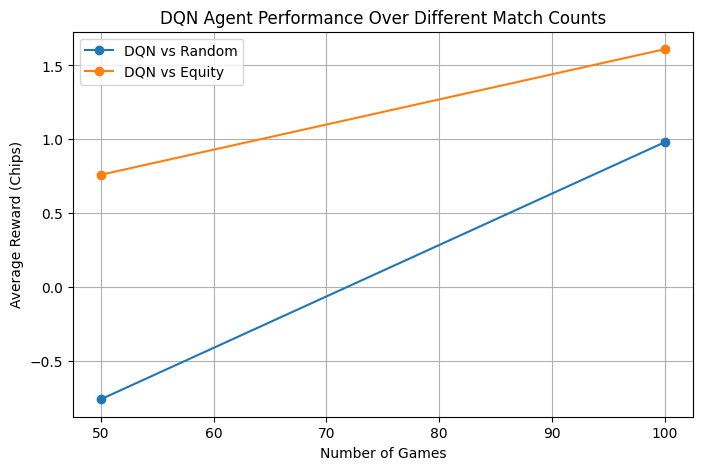

In [39]:
import matplotlib.pyplot as plt
import numpy as np
############
# - 画图 -
############

# —— 定义两个可调用策略 ——
random_agent = lambda env: random.choice(env._get_legal_moves())
equity_agent_fn = lambda env: equity_agent(env)  # equity_agent(env) 本身就返回动作

# 把它们和 DQN Agent 放到同一个 dict
agents = {
    'random': random_agent,
    'equity': equity_agent_fn,
    'dqn':    dqn_agent
}

types = {
    'random': 'random',
    'equity': 'equity',
    'dqn':    'dqn'
}

# 要测试的对阵
matchups = [
    ('dqn','random'),
    ('dqn','equity'),
]

# 不同对局数
game_counts = [50, 100]
mean_vs_random = []
mean_vs_equity = []

for n in game_counts:
    # DQN vs Random
    mr_rand, _ = evaluate_pair(
        env,
        agents['dqn'], agents['random'],
        types['dqn'], types['random'],
        n_games=n
    )
    mean_vs_random.append(mr_rand)

    # DQN vs Equity
    mr_equi, _ = evaluate_pair(
        env,
        agents['dqn'], agents['equity'],
        types['dqn'], types['equity'],
        n_games=n
    )
    mean_vs_equity.append(mr_equi)

# 画图
plt.figure(figsize=(8,5))
plt.plot(game_counts, mean_vs_random, marker='o', label='DQN vs Random')
plt.plot(game_counts, mean_vs_equity, marker='o', label='DQN vs Equity')
plt.xlabel('Number of Games')
plt.ylabel('Average Reward (Chips)')
plt.title('DQN Agent Performance Over Different Match Counts')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import random
import numpy as np
from collections import defaultdict
def discretize(obs):
    """
    将观测（stage_onehot, pot, hole_vals, comm_len）全部转为整数，
    再打包成 tuple 作为离散状态。
    """
    return tuple(int(x) for x in obs)

def train_qlearning(
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    eps_start=1.0,
    eps_decay=0.999,
    eps_min=0.1
):
    env = TexasHoldemEnv()
    Q = defaultdict(float)
    eps = eps_start

    for epi in range(1, n_episodes+1):
        obs = env.reset()
        s = discretize(obs)
        done = False

        while not done:
            # ε-greedy
            if random.random() < eps:
                a = random.choice(env._get_legal_moves())
            else:
                # 从合法动作中选择 Q 最大
                legal = env._get_legal_moves()
                qs = [Q[(s, a_)] for a_ in legal]
                a = legal[int(np.argmax(qs))]

            next_obs, r, done, info = env.step(a)
            s2 = discretize(next_obs)

            # Q 更新
            # 对后续状态，同样只在合法动作集合里取 max
            next_legal = env._get_legal_moves()
            best_next = max(Q[(s2, a_)] for a_ in next_legal)
            Q[(s, a)] += alpha * (r + gamma * best_next - Q[(s, a)])
            s = s2

        eps = max(eps_min, eps * eps_decay)
        if epi % 500 == 0:
            print(f"Episode {epi}/{n_episodes}, ε={eps:.3f}")

    return Q

# 运行训练
Q = train_qlearning(n_episodes=5000)

# 简单评估：在 1000 局中，看赢率
env = TexasHoldemEnv()
wins = 0
for _ in range(1000):
    obs = env.reset()
    s = discretize(obs)
    done = False
    while not done:
        legal = env._get_legal_moves()
        # 总选 Q 最大（无探索）
        qs = [Q[(s, a_)] for a_ in legal]
        a = legal[int(np.argmax(qs))]
        obs, r, done, info = env.step(a)
        s = discretize(obs)
    if info.get('result') == 'win':
        wins += 1

print(f"Q‑Learning agent win rate over 1000 games: {wins/10:.1f}%")

Episode 500/5000, ε=0.606
Episode 1000/5000, ε=0.368
Episode 1500/5000, ε=0.223
Episode 2000/5000, ε=0.135
Episode 2500/5000, ε=0.100
Episode 3000/5000, ε=0.100
Episode 3500/5000, ε=0.100
Episode 4000/5000, ε=0.100
Episode 4500/5000, ε=0.100
Episode 5000/5000, ε=0.100
Q‑Learning agent win rate over 1000 games: 31.0%


In [ ]:
# 累积后悔值和策略
regret_sum   = defaultdict(float)
strategy_sum = defaultdict(float)

def get_info_key(history, hole, community):
    """
    信息集键：手牌点数 + 公共牌数 + 动作历史拼接
    """
    hole_key = ''.join(sorted(str(card_value) for card_value in hole))
    comm_key = str(len(community))
    hist_key = ''.join(history)
    return f"{hole_key}|{comm_key}|{hist_key}"

def get_strategy(info_key, legal_moves):
    """
    根据累计后悔值最简单地做 Regret‑Matching：
    只在 legal_moves 上取正 regret，归一化
    """
    regrets = [max(regret_sum[(info_key,a)], 0) for a in legal_moves]
    total = sum(regrets)
    if total > 0:
        return [r/total for r in regrets]
    # 全零时均匀概率
    return [1/len(legal_moves)] * len(legal_moves)

def cfr(env, history, p0, p1, player):
    """
    递归 CFR 核心函数：
    - env: 当前环境
    - history: 过去动作名称列表
    - p0, p1: 到达概率（针对两位玩家）
    - player: 当前更新的是哪位玩家（0 或 1）
    """
    # 到 terminal
    if env.stage == Stage.SHOWDOWN or (history and history[-1] == 'FOLD'):
        # 用 env.cloned 环境模拟一次摊牌获得 payoff
        # 这里只为简化，直接读 env.step 后的 reward
        # （注意：严格 CFR 里需要完整信息集遍历）
        _, payoff, _, _ = env.step(Action.CALL.value)  # 触发终局
        return payoff if player == 0 else -payoff

    # 构造信息集
    info_key = get_info_key(history,
                            [card.rank for card in env.player_cards],
                            env.community_cards)
    legal = env._get_legal_moves()
    strat = get_strategy(info_key, legal)

    util = {}
    node_util = 0.0

    # 对每个合法动作递归
    for idx,a in enumerate(legal):
        new_env = copy.deepcopy(env)
        new_env.step(a)
        new_history = history + [Action(a).name]

        if player == 0:
            util[a] = cfr(new_env, new_history, p0*strat[idx], p1, player)
        else:
            util[a] = cfr(new_env, new_history, p0, p1*strat[idx], player)

        node_util += strat[idx] * util[a]

    # 累积后悔 & 策略
    for idx,a in enumerate(legal):
        regret   = util[a] - node_util
        weight   = (p1 if player==0 else p0)
        regret_sum[(info_key,a)]   += weight * regret
        strategy_sum[(info_key,a)] += (p0 if player==0 else p1) * strat[idx]

    return node_util

def train_cfr(iterations=2000):
    """
    交替更新两位玩家，每次从空 history 开始。
    """
    for i in range(1, iterations+1):
        base_env = TexasHoldemEnv()
        base_env.reset()
        cfr(copy.deepcopy(base_env), [], 1, 1, player=0)
        cfr(copy.deepcopy(base_env), [], 1, 1, player=1)
        if i % 500 == 0:
            print(f"CFR iter {i}/{iterations}")
    print("CFR training completed.")

# 启动训练
train_cfr(iterations=2000)


CFR iter 500/2000
CFR iter 1000/2000
CFR iter 1500/2000
CFR iter 2000/2000
CFR training completed.
